In [1]:
# based off https://github.com/pytorch/examples/blob/master/vae/main.py
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid

batch_size = 128 # input batch size for training
epochs = 10 # number of epochs to train
seed = 1 # random seed
log_interval = 100 # how many batches to wait before logging training status
lr = 1e-3 # learning rate

torch.manual_seed(seed)
device = "cpu"

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.xticks([]),plt.yticks([])
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [2]:
def getsubseq(dataset):
    subseq = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label == 9:
            subseq.append(i)
    return subseq

MNISTtrain = datasets.MNIST('MNIST', train=True, download=True,
                   transform=transforms.ToTensor())
MNISTtrainsub = torch.utils.data.Subset(MNISTtrain, getsubseq(MNISTtrain))
train_loader = torch.utils.data.DataLoader(
    MNISTtrainsub,
    batch_size=batch_size, shuffle=True)

MNISTtest = datasets.MNIST('MNIST', train=False, transform=transforms.ToTensor())
MNISTtestsub = torch.utils.data.Subset(MNISTtest, getsubseq(MNISTtest))
test_loader = torch.utils.data.DataLoader(
    MNISTtestsub,
    batch_size=batch_size, shuffle=False)

img_size = 28*28 # MNIST images are 28x28

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, med_size=400, lat_size=2):
        super(Autoencoder, self).__init__()

        self.fc1 = nn.Linear(img_size, med_size)
        self.fc2 = nn.Linear(med_size, lat_size)
        self.fc3 = nn.Linear(lat_size, med_size)
        self.fc4 = nn.Linear(med_size, img_size)
        
        self.lat_size = lat_size

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2(h1)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z), z
    
    def loss(self, x):
        recon_x, z = self.forward(x)
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        return BCE

In [4]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, med_size=400, lat_size=2, beta=1):
        super(VariationalAutoencoder, self).__init__()

        self.fc1 = nn.Linear(img_size, med_size)
        self.fc21 = nn.Linear(med_size, lat_size)
        self.fc22 = nn.Linear(med_size, lat_size)
        self.fc3 = nn.Linear(lat_size, med_size)
        self.fc4 = nn.Linear(med_size, img_size)
        self.beta = beta
        
        self.lat_size = lat_size

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    # Reconstruction + KL divergence losses summed over all elements and batch
    def loss(self, x):
        recon_x, mu, logvar = self.forward(x)
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + self.beta * KLD

In [5]:
def train(model, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        loss = model.loss(data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [6]:
def test(model, optimizer, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)[0]
            test_loss += model.loss(data).item()
            #test_loss += BCE_loss(recon_batch, data).item()
            #if i == 0:
            #    n = min(data.size(0), 8)
            #    comparison = torch.cat([data[:n],
            #                          recon_batch.view(batch_size, 1, 28, 28)[:n]])
            #    show(make_grid(comparison.cpu(), nrow=n))

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [7]:
def learn(model, epochs):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(1, epochs + 1):
        train(model, optimizer, epoch)
        test(model, optimizer, epoch)
#with torch.no_grad():
#    sample = torch.tensor(latentpars).to(device)
#    sample = model.decode(sample).cpu()
#    show(make_grid(sample.view(64, 1, 28, 28)))

In [8]:
def show_recon(model):
    with torch.no_grad():
        for i, (data, _) in enumerate(train_loader):
            if i == 0:
                data = data.to(device)
                recon_batch = model(data)[0]

                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                show(make_grid(comparison.cpu(), nrow=n))

In [9]:
def show_encoding(model, axes=(0,1)):
    for i, (data, label) in enumerate(train_loader):
        with torch.no_grad():
            data = data.to(device)
            mu = model(data.view(-1, 784))[1]
            plt.scatter(mu[:,axes[0]], mu[:,axes[1]], c='b', alpha=0.1)   
    plt.show()

In [10]:
def show_grid(model, axes=(0,1), nsamp=16):
    latentpars = np.zeros((nsamp, nsamp, model.lat_size), dtype=np.float32)
    linspace = np.linspace(-5,5,nsamp)
    latentpars[:,:,axes[0]] = linspace[None,:]
    latentpars[:,:,axes[1]] = linspace[:,None]
    latentpars = latentpars.reshape((nsamp*nsamp,model.lat_size))
    plt.figure(figsize=(16,16))
    with torch.no_grad():
        sample = torch.tensor(latentpars).to(device)
        sample = model.decode(sample).cpu()
        show(make_grid(sample.view(nsamp*nsamp, 1, 28, 28), nrow=nsamp))

In [11]:
AC = Autoencoder().to(device)
learn(AC, 10)

Train Epoch: 1 [0/5949 (0%)]	Loss: 548.632874
====> Epoch: 1 Average loss: 216.8556
====> Test set loss: 147.1424
Train Epoch: 2 [0/5949 (0%)]	Loss: 151.911896
====> Epoch: 2 Average loss: 140.9431
====> Test set loss: 134.4174
Train Epoch: 3 [0/5949 (0%)]	Loss: 139.188049
====> Epoch: 3 Average loss: 131.8883
====> Test set loss: 128.5449
Train Epoch: 4 [0/5949 (0%)]	Loss: 129.772552
====> Epoch: 4 Average loss: 127.7969
====> Test set loss: 125.7875
Train Epoch: 5 [0/5949 (0%)]	Loss: 126.730072
====> Epoch: 5 Average loss: 125.5303
====> Test set loss: 124.3352
Train Epoch: 6 [0/5949 (0%)]	Loss: 125.512817
====> Epoch: 6 Average loss: 124.2165
====> Test set loss: 123.2681
Train Epoch: 7 [0/5949 (0%)]	Loss: 129.686981
====> Epoch: 7 Average loss: 123.2642
====> Test set loss: 122.5150
Train Epoch: 8 [0/5949 (0%)]	Loss: 122.917770
====> Epoch: 8 Average loss: 122.4549
====> Test set loss: 121.6189
Train Epoch: 9 [0/5949 (0%)]	Loss: 120.521385
====> Epoch: 9 Average loss: 121.7244
====

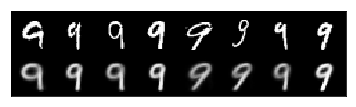

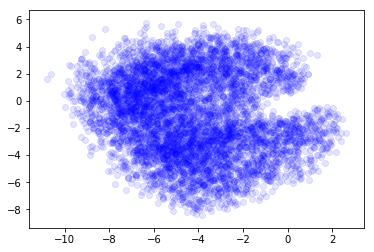

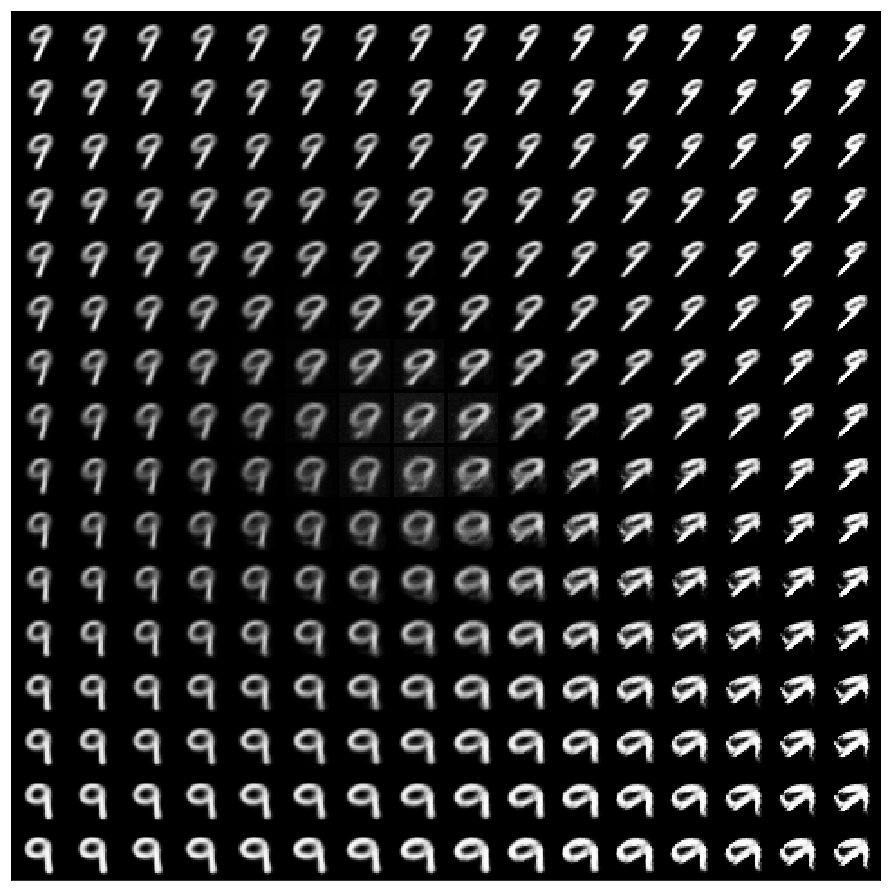

In [12]:
show_recon(AC)
show_encoding(AC)
show_grid(AC)

In [13]:
def show_traverse(model, nsamp=8):
    with torch.no_grad():
        # find average variance in each dimension
        avgvar = np.zeros(model.lat_size)
        nvar = 0
        for i, (data, _) in enumerate(train_loader):
            data = data.to(device)
            logvar = model(data)[2].numpy()
            avgvar += np.exp(logvar).sum(axis=0)
            nvar += logvar.shape[0]
        avgvar /= nvar
        # sort dimensions from smallest variance to largest
        sortdims = np.argsort(avgvar)
        linspace = np.linspace(-5,5,nsamp)
        _, z0, var = model.forward(MNISTtestsub.__getitem__(42)[0])
        latentpars = np.zeros((model.lat_size*nsamp, model.lat_size)).astype(np.float32)
        for i in range(sortdims.size):
            j = sortdims[i]
            latentpars[i*nsamp:(i+1)*nsamp,:] = z0[None,:]
            latentpars[i*nsamp:(i+1)*nsamp,j] = linspace
        sample = torch.tensor(latentpars).to(device)
        sample = model.decode(sample).cpu()
        show(make_grid(sample.view(model.lat_size*nsamp, 1, 28, 28), nrow=nsamp))

In [14]:
VAC = VariationalAutoencoder().to(device)
learn(VAC, 10)

Train Epoch: 1 [0/5949 (0%)]	Loss: 549.742004
====> Epoch: 1 Average loss: 227.3545
====> Test set loss: 160.0726
Train Epoch: 2 [0/5949 (0%)]	Loss: 158.312210
====> Epoch: 2 Average loss: 148.3042
====> Test set loss: 138.7895
Train Epoch: 3 [0/5949 (0%)]	Loss: 139.423492
====> Epoch: 3 Average loss: 137.4362
====> Test set loss: 134.3974
Train Epoch: 4 [0/5949 (0%)]	Loss: 136.082626
====> Epoch: 4 Average loss: 134.0013
====> Test set loss: 132.0924
Train Epoch: 5 [0/5949 (0%)]	Loss: 135.424896
====> Epoch: 5 Average loss: 131.9154
====> Test set loss: 130.5494
Train Epoch: 6 [0/5949 (0%)]	Loss: 128.838989
====> Epoch: 6 Average loss: 130.2821
====> Test set loss: 129.0207
Train Epoch: 7 [0/5949 (0%)]	Loss: 124.866516
====> Epoch: 7 Average loss: 128.7828
====> Test set loss: 127.3725
Train Epoch: 8 [0/5949 (0%)]	Loss: 126.948753
====> Epoch: 8 Average loss: 127.1799
====> Test set loss: 125.3248
Train Epoch: 9 [0/5949 (0%)]	Loss: 125.017746
====> Epoch: 9 Average loss: 125.7467
====

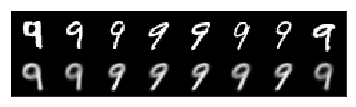

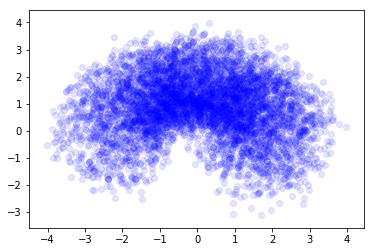

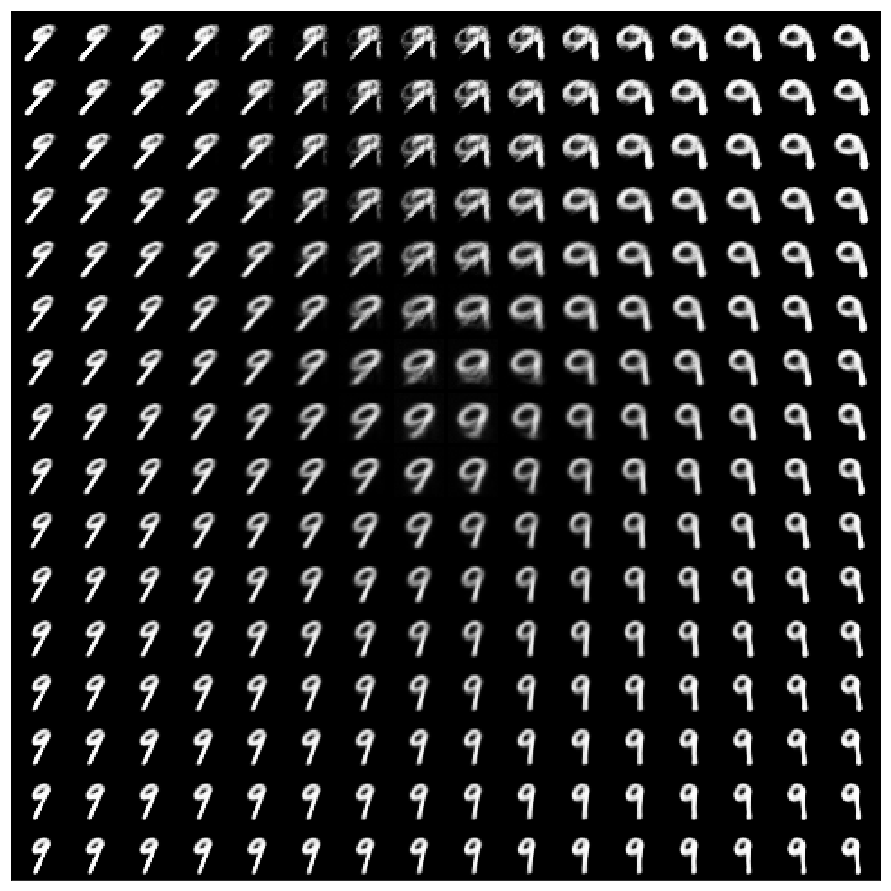

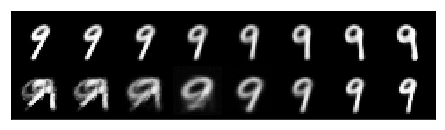

In [15]:
show_recon(VAC)
show_encoding(VAC)
show_grid(VAC)
plt.figure(figsize=(8,2))
show_traverse(VAC)

In [16]:
VAC_big = VariationalAutoencoder(lat_size=20).to(device)
learn(VAC_big, 10)

Train Epoch: 1 [0/5949 (0%)]	Loss: 551.357239
====> Epoch: 1 Average loss: 237.5327
====> Test set loss: 166.1865
Train Epoch: 2 [0/5949 (0%)]	Loss: 172.421249
====> Epoch: 2 Average loss: 156.0176
====> Test set loss: 141.6037
Train Epoch: 3 [0/5949 (0%)]	Loss: 144.598007
====> Epoch: 3 Average loss: 137.6139
====> Test set loss: 131.8875
Train Epoch: 4 [0/5949 (0%)]	Loss: 133.246124
====> Epoch: 4 Average loss: 130.1903
====> Test set loss: 124.7676
Train Epoch: 5 [0/5949 (0%)]	Loss: 123.208626
====> Epoch: 5 Average loss: 123.0141
====> Test set loss: 118.4763
Train Epoch: 6 [0/5949 (0%)]	Loss: 122.913773
====> Epoch: 6 Average loss: 118.1815
====> Test set loss: 114.7248
Train Epoch: 7 [0/5949 (0%)]	Loss: 116.911972
====> Epoch: 7 Average loss: 114.7733
====> Test set loss: 111.8597
Train Epoch: 8 [0/5949 (0%)]	Loss: 110.254562
====> Epoch: 8 Average loss: 111.4186
====> Test set loss: 108.8314
Train Epoch: 9 [0/5949 (0%)]	Loss: 109.094955
====> Epoch: 9 Average loss: 108.2625
====

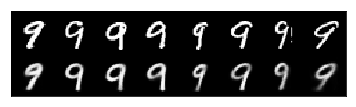

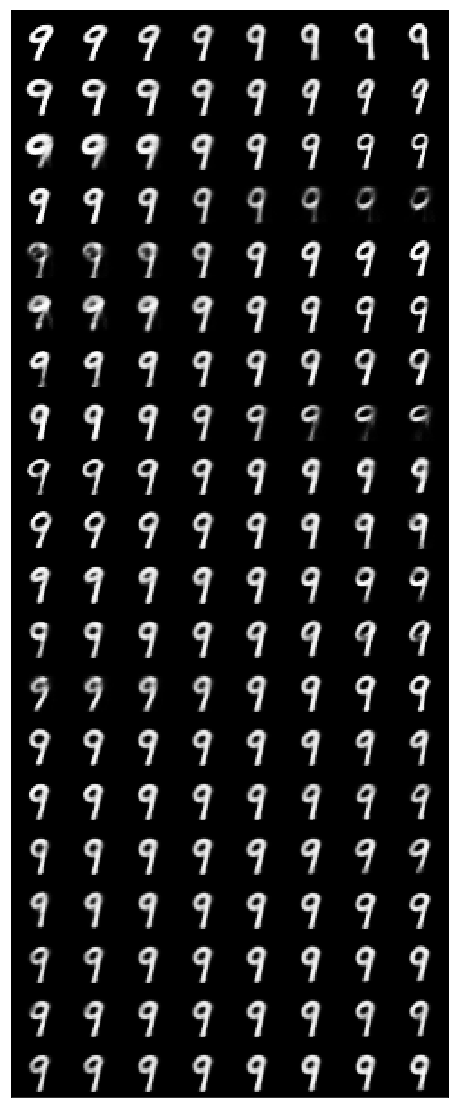

In [17]:
show_recon(VAC_big)
plt.figure(figsize=(8,20))
show_traverse(VAC_big)

In [18]:
BVAC = VariationalAutoencoder(lat_size=20, beta=2).to(device)
learn(BVAC, 10)

Train Epoch: 1 [0/5949 (0%)]	Loss: 551.555298
====> Epoch: 1 Average loss: 243.7731
====> Test set loss: 169.7001
Train Epoch: 2 [0/5949 (0%)]	Loss: 167.191803
====> Epoch: 2 Average loss: 161.6603
====> Test set loss: 149.0332
Train Epoch: 3 [0/5949 (0%)]	Loss: 147.451279
====> Epoch: 3 Average loss: 144.8175
====> Test set loss: 138.7460
Train Epoch: 4 [0/5949 (0%)]	Loss: 134.715805
====> Epoch: 4 Average loss: 138.1232
====> Test set loss: 134.4705
Train Epoch: 5 [0/5949 (0%)]	Loss: 136.044739
====> Epoch: 5 Average loss: 133.7708
====> Test set loss: 129.1964
Train Epoch: 6 [0/5949 (0%)]	Loss: 131.184433
====> Epoch: 6 Average loss: 128.7980
====> Test set loss: 125.3696
Train Epoch: 7 [0/5949 (0%)]	Loss: 127.502121
====> Epoch: 7 Average loss: 125.2366
====> Test set loss: 122.5246
Train Epoch: 8 [0/5949 (0%)]	Loss: 127.005234
====> Epoch: 8 Average loss: 122.9151
====> Test set loss: 120.2969
Train Epoch: 9 [0/5949 (0%)]	Loss: 127.046402
====> Epoch: 9 Average loss: 120.8282
====

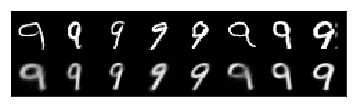

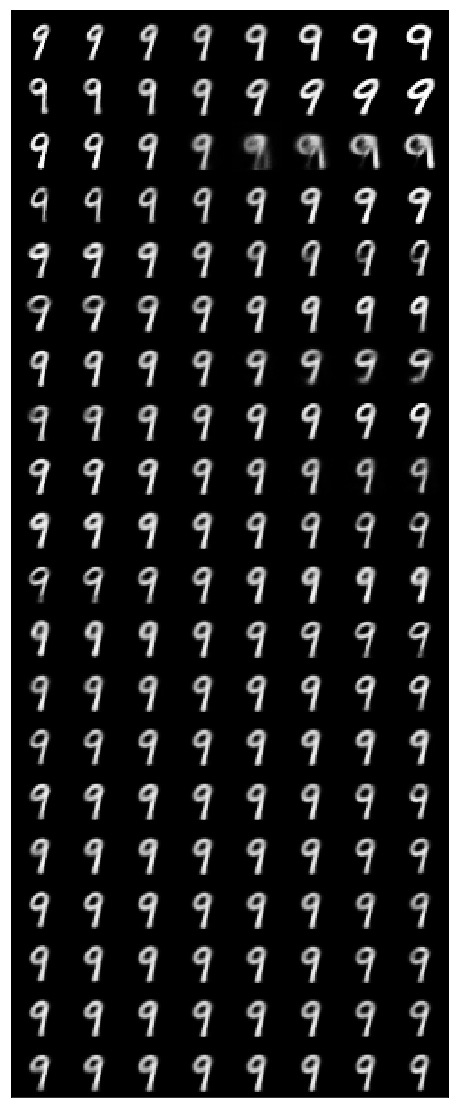

In [19]:
show_recon(BVAC)
plt.figure(figsize=(8,20))
show_traverse(BVAC)